In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
#Read in the csv file
diabetes_df = pd.read_csv('Dataset/diabetes.csv')

diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
diabetes_df = diabetes_df.rename(columns={'DiabetesPedigreeFunction':'DPF'})
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


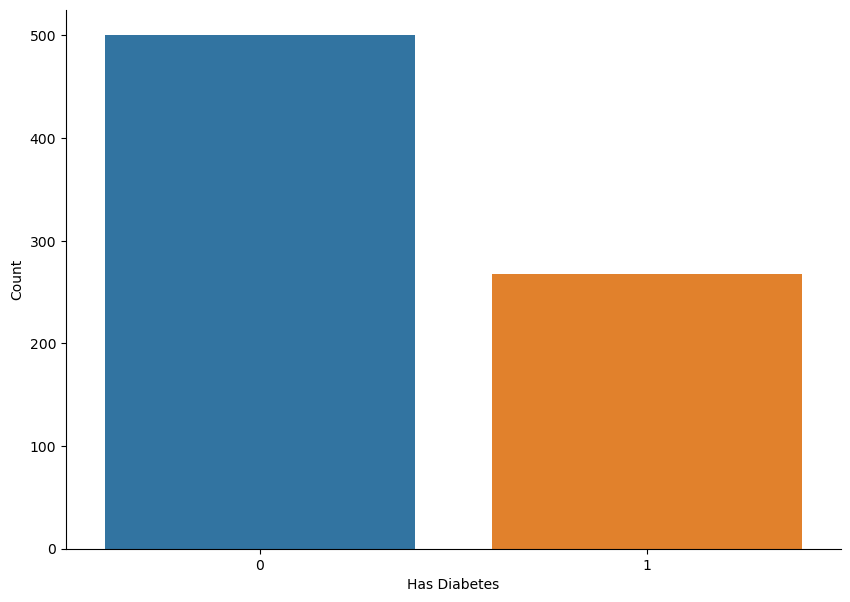

In [5]:
# Plotting the Outcomes based on the number of dataset entries
plt.figure(figsize=(10,7))
sns.countplot(x='Outcome', data=diabetes_df)

# Removing the unwanted spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Headings
plt.xlabel('Has Diabetes')
plt.ylabel('Count')

plt.show()

In [6]:
# Replace the 0 values from ['Glucose','BloodPressure','SkinThickness','Insulin','BMI'] by NaN
df_copy = diabetes_df.copy(deep=True)
df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
df_copy.isnull().sum()

Pregnancies        0
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
DPF                0
Age                0
Outcome            0
dtype: int64

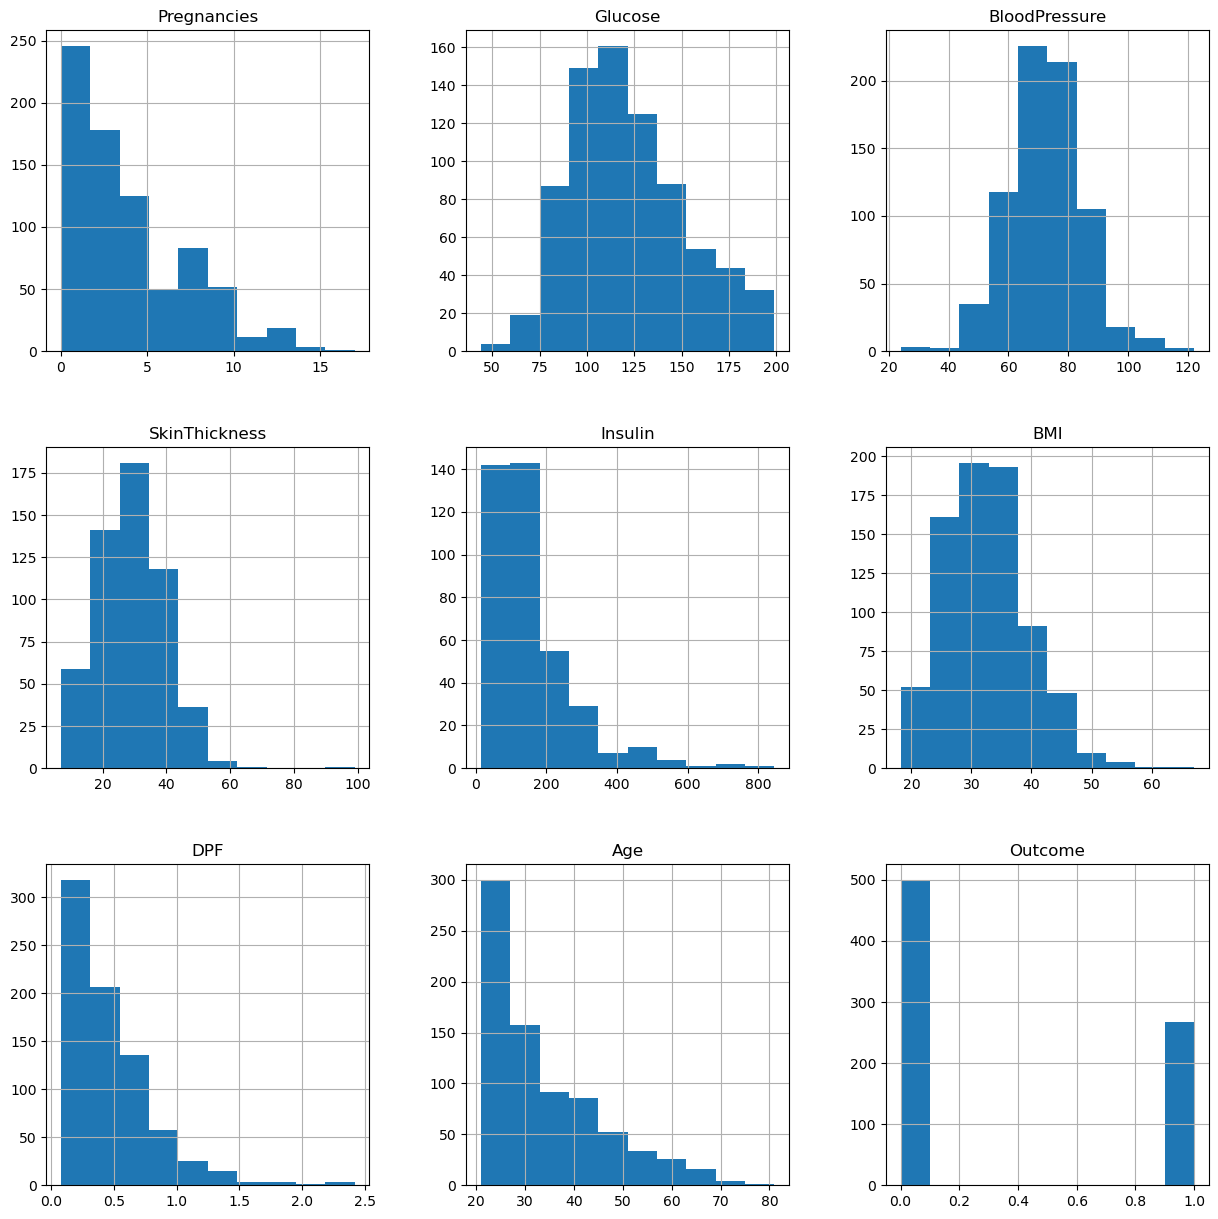

In [7]:
# To fill these Nan values the data distribution needs to be understood
# Plotting histogram of dataset before replacing NaN values
p = df_copy.hist(figsize = (15,15))

In [8]:
# Replacing NaN value by mean, median depending upon distribution
df_copy['Glucose'].fillna(df_copy['Glucose'].mean(), inplace=True)
df_copy['BloodPressure'].fillna(df_copy['BloodPressure'].mean(), inplace=True)
df_copy['SkinThickness'].fillna(df_copy['SkinThickness'].median(), inplace=True)
df_copy['Insulin'].fillna(df_copy['Insulin'].median(), inplace=True)
df_copy['BMI'].fillna(df_copy['BMI'].median(), inplace=True)

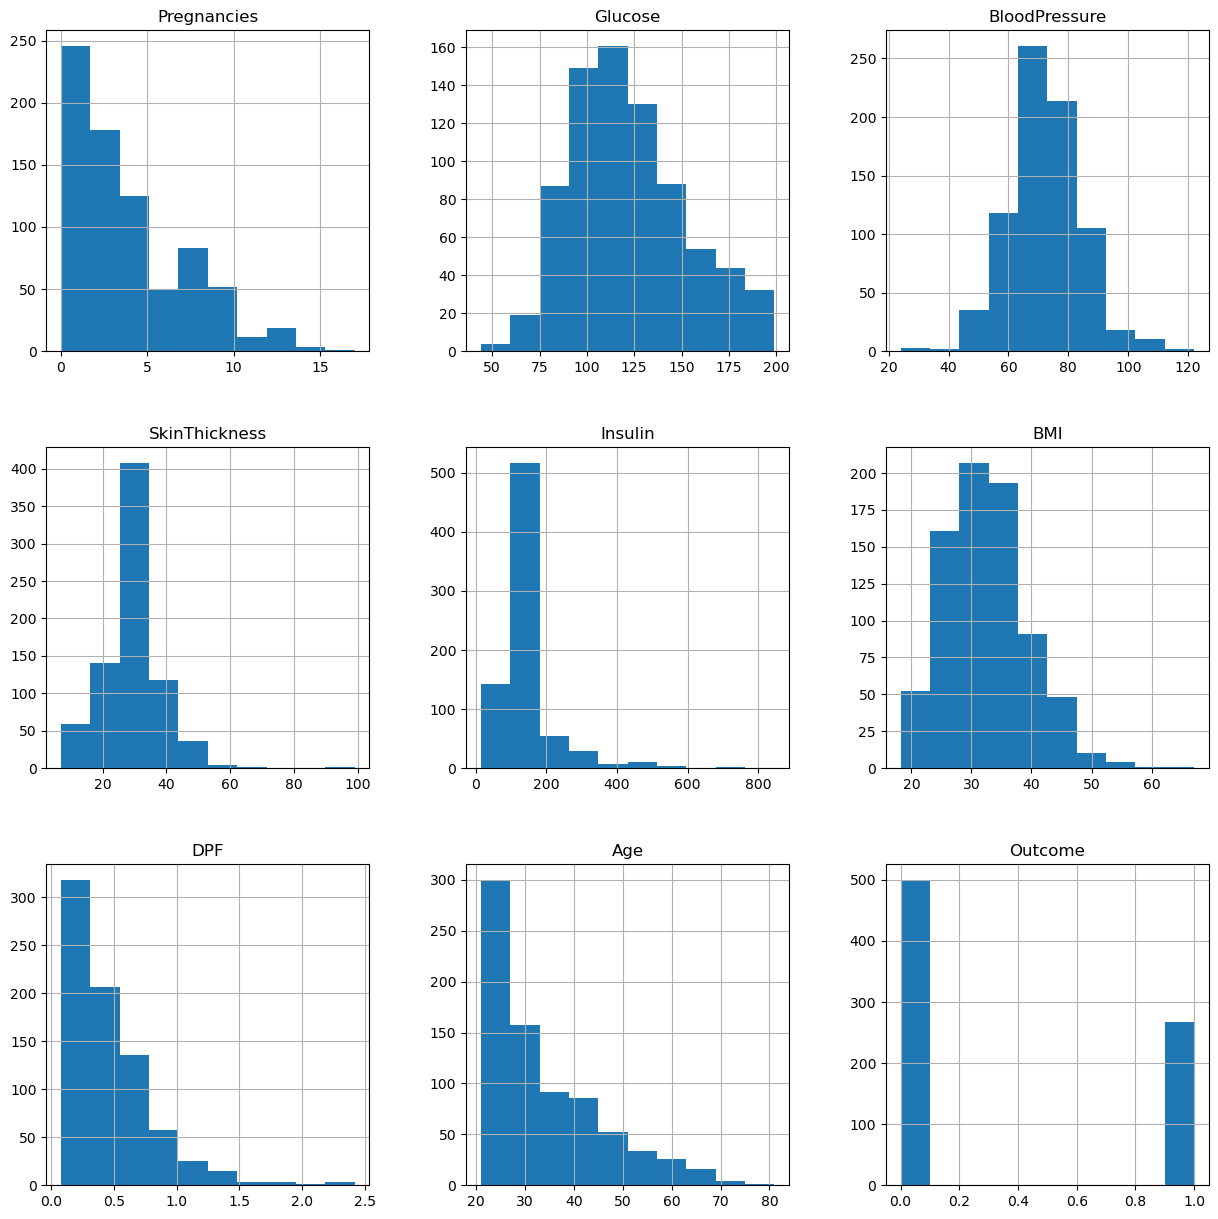

In [9]:
# Plotting histogram of dataset after replacing NaN values
p = df_copy.hist(figsize=(15,15))

In [10]:
df_copy.isnull().sum()

Pregnancies      0
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
DPF              0
Age              0
Outcome          0
dtype: int64

# Model Building

In [11]:
X = diabetes_df.drop(columns='Outcome')
y = diabetes_df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))

X_train size: (614, 8), X_test size: (154, 8)


In [12]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [13]:
# Creating a function to calculate best model for this problem
def find_best_model(X, y):
    models = {
        'logistic_regression': {
            'model': LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000),
            'parameters': {
                'C': [1, 5, 10]
            }
        },
        'decision_tree': {
            'model': DecisionTreeClassifier(splitter='best'),
            'parameters': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [5, 10]
            }
        },
        'random_forest': {
            'model': RandomForestClassifier(criterion='gini'),
            'parameters': {
                'n_estimators': [10, 15, 20, 50, 100, 200]
            }
        },
        'svm': {
            'model': SVC(gamma='auto'),
            'parameters': {
                'C': [1, 10, 20],
                'kernel': ['rbf', 'linear']
            }
        }
    }

    scores = []
    cv_shuffle = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)

    for model_name, model_params in models.items():
        gs = GridSearchCV(model_params['model'], model_params['parameters'], cv=cv_shuffle, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': model_name,
            'best_parameters': gs.best_params_,
            'score': gs.best_score_
        })

    return pd.DataFrame(scores, columns=['model', 'best_parameters', 'score'])


find_best_model(X_train, y_train)

,model,best_parameters,score
0,logistic_regression,{'C': 1},0.778862
1,decision_tree,"{'criterion': 'entropy', 'max_depth': 5}",0.707317
2,random_forest,{'n_estimators': 200},0.751220
3,svm,"{'C': 1, 'kernel': 'linear'}",0.777236


In [14]:
# Using cross_val_score for gaining average accuracy
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RandomForestClassifier(n_estimators=20, random_state=1), X_train, y_train, cv=5)
print('Average Accuracy : {}%'.format(round(sum(scores)*100/len(scores)), 3))

Average Accuracy : 75%


In [15]:
# Creating Random Forest Model
classifier = RandomForestClassifier(n_estimators=20, random_state=1)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=1)

## Evaluation

In [16]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[89, 10],
       [23, 32]], dtype=int64)

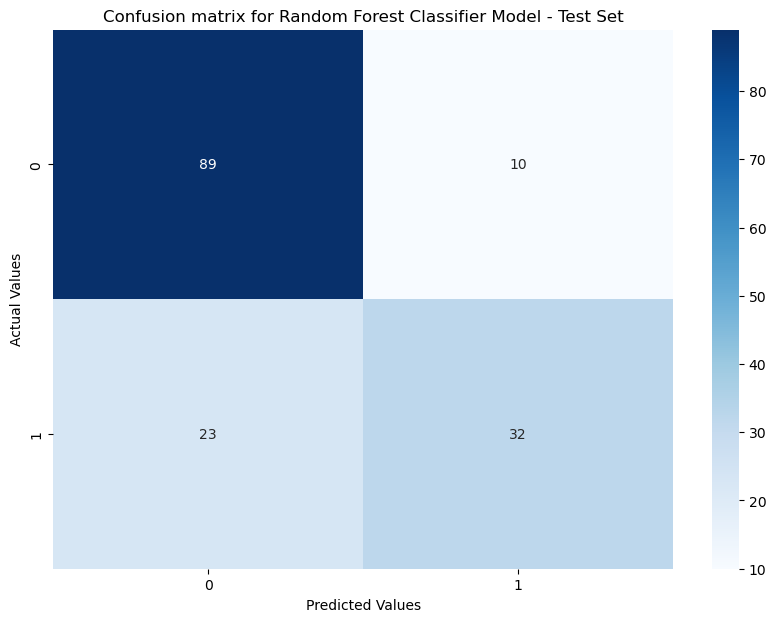

In [17]:
# Plot the confusion matrix
plt.figure(figsize=(10,7))
p = sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion matrix for Random Forest Classifier Model - Test Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [18]:
# Accuracy Score
score = round(accuracy_score(y_test, y_pred),4)*100
print("Accuracy on test set: {}%".format(score))

Accuracy on test set: 78.57%


In [19]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        99
           1       0.76      0.58      0.66        55

    accuracy                           0.79       154
   macro avg       0.78      0.74      0.75       154
weighted avg       0.78      0.79      0.78       154



In [20]:
# Creating a confusion matrix for training set
y_train_pred = classifier.predict(X_train)
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[401,   0],
       [  5, 208]], dtype=int64)

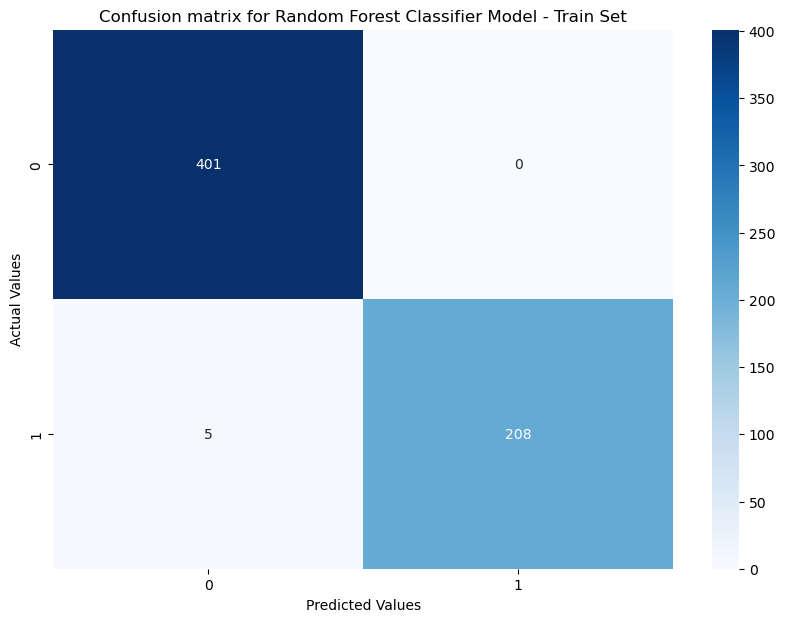

In [21]:
# Plotting the confusion matrix
plt.figure(figsize=(10,7))
p = sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion matrix for Random Forest Classifier Model - Train Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [22]:
# Accuracy Score
score = round(accuracy_score(y_train, y_train_pred),4)*100
print("Accuracy on trainning set: {}%".format(score))

Accuracy on trainning set: 99.19%


In [23]:
# Classification Report
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       401
           1       1.00      0.98      0.99       213

    accuracy                           0.99       614
   macro avg       0.99      0.99      0.99       614
weighted avg       0.99      0.99      0.99       614



## Prediction tests

In [24]:
# Creating a function for prediction

def predict_diabetes(Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age):
    preg = int(Pregnancies)
    glucose = float(Glucose)
    bp = float(BloodPressure)
    st = float(SkinThickness)
    insulin = float(Insulin)
    bmi = float(BMI)
    dpf = float(DPF)
    age = int(Age)

    x = [[preg, glucose, bp, st, insulin, bmi, dpf, age]]
    x = sc.transform(x)

    return classifier.predict(x)

In [25]:
# Prediction 1
# Input sequence: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age
prediction = predict_diabetes(2, 81, 72, 15, 76, 30.1, 0.547, 25)[0]
if prediction:
  print('You have diabetes.')
else:
  print("You don't have diabetes.")

You don't have diabetes.


In [26]:
# Prediction 2
prediction = predict_diabetes(1, 70, 55, 23, 96, 26.5, 0.166, 30)[0]
if prediction:
    print('You have diabetes.')
else:
    print("You don't have diabetes.")

You don't have diabetes.


In [27]:
# Prediction 2
prediction = predict_diabetes(5, 111, 78, 40, 190, 33.1, 1.221, 62)[0]
if prediction:
    print('You have diabetes.')
else:
    print("You don't have diabetes.")

You have diabetes.
